<a href="https://colab.research.google.com/github/previoip/rf-playground/blob/main/spherical_interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

sorry to disappoint: there aren't any billiards. no propag, no raytrace, no custom emission pattern, no nothing. Only spherical sine standing wave generator to observe collective interference interactions.

There's no practical use for this other than generating cool looking graph.

To see billiards animation in action, check https://www.youtube.com/@NilsBerglund

Practical use of wave interference observation on optics see https://www.youtube.com/@HuygensOptics

License: https://unlicense.org/

In [1]:
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
os.makedirs('./exports', exist_ok=True)

In [2]:
class SphericalInterferencePattern:

  class OmniSource:
    def __init__(self, x, y, frequency, amplitude, phase=0, falloff_exp=0):
      self.x = x
      self.y = y
      self.f = frequency
      self.a = amplitude
      self.p = phase
      self.k = falloff_exp


  def __init__(self,
               speed_constant,
               scale_x=10,
               scale_y=10,
               res_x=251,
               res_y=251,
               offset_x=0,
               offset_y=0):
    self.c = speed_constant
    self.scale_x = scale_x
    self.scale_y = scale_y
    self.res_x = res_x
    self.res_y = res_y
    self.offset_x = offset_x
    self.offset_y = offset_y

    self.sources = list()
    self.A = np.zeros((self.res_y, self.res_x))

    self.indices_x = np.arange(self.res_x, dtype=np.int32)
    self.indices_y = np.arange(self.res_y, dtype=np.int32)
    xx, yy = np.meshgrid(self.indices_x, self.indices_y)
    self.indices = np.vstack([xx.ravel(), yy.ravel()]).T

    self.samples_x = np.linspace(-self.scale_x/2, self.scale_x/2, self.res_x)
    self.samples_y = np.linspace(-self.scale_y/2, self.scale_y/2, self.res_y)
    self.samples_x += self.offset_x
    self.samples_y += self.offset_y
    xx, yy = np.meshgrid(self.samples_x, self.samples_y)
    self.samples = np.vstack([xx.ravel(), yy.ravel()]).T


  def update(self, t=0):
    self.A *= 0
    for source in self.sources:
      d = np.linalg.norm(self.samples - (source.x, source.y), axis=1)
      l = self.c / source.f / np.pi / 2
      k = 2 * np.pi / l
      A = np.cos((k*d) - source.p) * source.a
      A *= np.exp(d * source.k)
      self.A[self.indices[:, 1], self.indices[:, 0]] += A


  @wraps(OmniSource)
  def new_source(self, *args, **kwargs):
    self.sources.append(self.OmniSource(*args, **kwargs))


  def render_amplitude(self, ax):
    ax.contourf(self.samples_x, self.samples_y, self.A)


  def render_power(self, ax):
    ax.contourf(self.samples_x, self.samples_y, self.A**2)


  def render_source_points(self, ax):
    x = [s.x for s in self.sources]
    y = [s.y for s in self.sources]
    ax.scatter(x, y, c='black', marker='.')



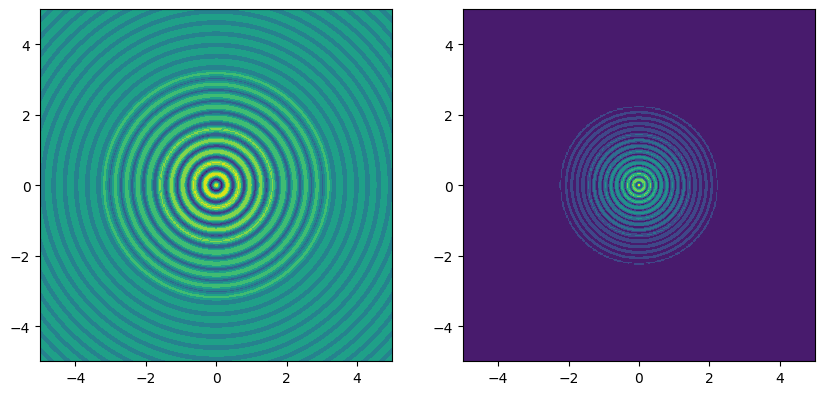

In [3]:
# single source showing amplitude and standing wave power

# note units are arbitrary, rule of thumb -> wavelength = speed / frequency

o = SphericalInterferencePattern(1000)
o.new_source(0, 0, 500, 1, falloff_exp=-0.4, phase=0)
o.update()

plt.close() # ensure any pyplot handlers are closed before creating a new one
fig, ax = plt.subplots(1, 2, figsize=(10,5))
o.render_amplitude(ax[0])
o.render_power(ax[1])
ax[0].axis('scaled')
ax[1].axis('scaled')

fig.savefig('./exports/single.webp')

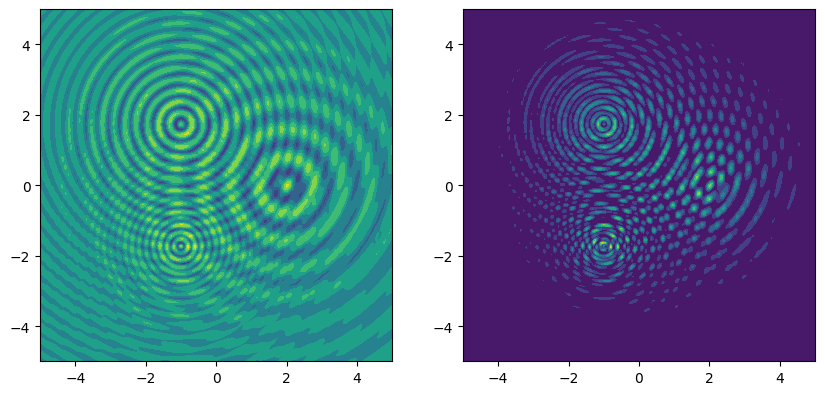

In [4]:
# three sources with varying falloff and frequency

o = SphericalInterferencePattern(1000)
o.new_source(2*np.cos(np.pi*0/3), 2*np.sin(np.pi*0/3), 200, 1, falloff_exp=-0.4, phase=0)
o.new_source(2*np.cos(np.pi*2/3), 2*np.sin(np.pi*2/3), 500, 1, falloff_exp=-0.3, phase=0)
o.new_source(2*np.cos(np.pi*4/3), 2*np.sin(np.pi*4/3), 800, 1, falloff_exp=-0.8, phase=0)
o.update()

plt.close()
fig, ax = plt.subplots(1, 2, figsize=(10,5))
o.render_amplitude(ax[0])
o.render_power(ax[1])
ax[0].axis('scaled')
ax[1].axis('scaled')

fig.savefig('./exports/three.webp')

In [5]:
# the rest are animated, requires ffmpeg to run

import subprocess, sys
from IPython.display import Image

def export_frames_as_gif(folder, prefix, export_filepath, frame_rate):
  subprocess.Popen([
    'ffmpeg',
    '-y',
    # '-loglevel', 'quiet',
    '-f', 'image2',
    '-framerate', str(frame_rate),
    '-i', f'{folder}/{prefix}%04d.webp',
    export_filepath
  ])
  return Image(url=export_filepath)


In [6]:
# animated two sources with varying distance

FRAMES_COUNT = 50
FPS = 25
DIST_SWEEP = 3
FREQUENCY = 400

if os.path.exists('./frames_two_sources'):
  shutil.rmtree('./frames_two_sources')
os.makedirs('./frames_two_sources')

o = SphericalInterferencePattern(1000)
o.new_source(0, 0, FREQUENCY, 1, falloff_exp=-0.25, phase=0)
o.new_source(0, 0, FREQUENCY, 1, falloff_exp=-0.25, phase=0)

for i in range(FRAMES_COUNT):
  r = i / (FRAMES_COUNT-1)
  fig, ax = plt.subplots(1, 2, figsize=(10,5))
  o.sources[0].x = DIST_SWEEP / 2 * -r
  o.sources[1].x = DIST_SWEEP / 2 * r
  o.update()
  o.render_amplitude(ax[0])
  o.render_power(ax[1])
  ax[0].axis('scaled')
  ax[1].axis('scaled')
  fig.savefig(f'./frames_two_sources/frame_{i:04d}.webp')
  plt.close()

export_frames_as_gif('./frames_two_sources', 'frame_', './exports/two_sources.gif', FPS)


In [7]:
# animated phased array

FRAMES_COUNT = 50
FPS = 25
N_ANTENNAS = 8
DIST_MODIFIER = 3
FREQUENCY = 400
PHASE_SWEEP = 180.0

if os.path.exists('./frames_phased_array'):
  shutil.rmtree('./frames_phased_array')
os.makedirs('./frames_phased_array')

o = SphericalInterferencePattern(1000)
wavelength = o.c / FREQUENCY / np.pi / 2

for n in range(N_ANTENNAS):
  r = n / (N_ANTENNAS-1) - .5
  o.new_source(wavelength*r*(DIST_MODIFIER+.25), 0, FREQUENCY, 1)

for i in range(FRAMES_COUNT):
  r = i / (FRAMES_COUNT-1) * 2 - 1
  phase = PHASE_SWEEP * r / 180 * np.pi
  for n, src in enumerate(o.sources):
    src.p = phase * n
  fig, ax = plt.subplots(1, 2, figsize=(10,5))
  o.update()
  o.render_amplitude(ax[0])
  o.render_power(ax[1])
  o.render_source_points(ax[0])
  o.render_source_points(ax[1])
  ax[0].axis('scaled')
  ax[1].axis('scaled')
  fig.savefig(f'./frames_phased_array/frame_{i:04d}.webp')
  plt.close()

export_frames_as_gif('./frames_phased_array', 'frame_', './exports/phased_array.gif', FPS)